# Project: Write a Data Science Blog Post

## Business Understanding

### Business Questions
This analysis addresses the following:

- What factors most influence the price of an Airbnb listing in Albany?
- Is there a correlation between listing price and availability throughout the year? Is there a correlation between the number of reviews and availability?
- Are there location-based trends in average price, number of reviews, or review frequency in Albany?
- How does the room type affect the average price and availability of listings?
- Do listings with more frequent reviews tend to have higher/lower prices or higher/lower availability?


## 1- Gather
The first step in any data science project is to gather the data. For this project, we will load the dataset using a custom function with robust error handling to ensure smooth operation even if issues arise with the file.


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from tabulate import tabulate
import seaborn as sns
%matplotlib inline

# 1. Load Data Function
def load_data(file_path):
    """
    Load a CSV file into a DataFrame with error handling.

    Parameters:
    file_path (str): Path to the CSV file.

    Returns:
    pd.DataFrame: Loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data from {file_path}\n")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The file {file_path} was not found.")
    except pd.errors.EmptyDataError:
        raise ValueError("Error: The file is empty.")
    except pd.errors.ParserError:
        raise ValueError("Error: The file could not be parsed.")

# Opening data file 
file_path = 'listings.csv'

try:
    # Step-by-step execution of the data pipeline
    df = load_data(file_path)                   # Load data
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded data from listings.csv



## 2- Assess and Analyze
In Assess step, we will assess the dataset for potential issues such as missing values, incorrect data types, and duplicate rows. This will guide the cleaning process.

Then Analyze step focuses on exploring the data to uncover trends, correlations, and other insights that can inform the modeling process.



### Are there any missing values or unusual patterns in the dataset?  
To build reliable models and gain insights, it's essential to understand the data quality.  
- We explore missing values, data types, and summary statistics.  
- This step helps identify potential data cleaning needs and unusual trends that may affect further analysis.  


In [59]:
def display_data_info(df):
    """
    Assess and analyze the DataFrame.

    Steps:
    1. **Assess Step**:
        - Overview of the dataset: Number of rows and columns.
        - Missing data: Count and percentage of missing values in each column.
        - Data types: Types of data in each column.
        - Duplicate rows: Number of duplicate rows.
        - Unique values: Count of unique values for each column.

    2. **Analyze Step**:
        - Numerical data summary: Descriptive statistics for numerical columns.
        - Categorical data summary: Descriptive statistics for categorical columns.
        - Correlation matrix: Correlation between numerical columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Outputs:
    Prints a detailed assessment and analysis of the dataset, including:
    - Missing data information.
    - Data type details.
    - Summary statistics for numerical and categorical columns.
    - Unique values per column.
    - Correlation matrix for numerical data.
    """
    print("\n--- Assess Step: Dataset Overview ---\n")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")

    # Missing Data Information
    print("\n--- Missing Data Information ---")
    missing_counts = df.isna().sum()
    num_cols_missing = (missing_counts > 0).sum()
    print(f"Number of columns with missing data: {num_cols_missing}")

    if num_cols_missing > 0:  # Only show details if there are any missing values.
        missing_percentage = (missing_counts / len(df)) * 100
        missing_info = pd.DataFrame({
            'Missing Count': missing_counts,
            'Missing Percentage': missing_percentage
        }).round(2)
        print(tabulate(
            missing_info,
            headers='keys',
            tablefmt='pretty',
            showindex=True
        ))  # Show index (column names)

    # Data Type Information
    print("\n--- Data Types ---")
    print(tabulate(
        df.dtypes.reset_index(),
        headers=['Column', 'Data Type'],
        tablefmt='pretty'
    ))

    # Duplicate Rows
    duplicate_count = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")

    # Unique Values
    print("\n--- Unique Values per Column ---")
    print(tabulate(
        df.nunique().reset_index(),
        headers=['Column', 'Unique Values'],
        tablefmt='pretty'
    ))

    print("\n--- Analyze Step: Exploring Data ---\n")

    # Summary Statistics (Numerical Data)
    print("\n--- Numerical Data Summary ---")
    numerical_summary = df.describe(include=np.number).round(2)
    print(tabulate(numerical_summary, headers='keys', tablefmt='pretty'))

    # Summary Statistics (Categorical Data)
    print("\n--- Categorical Data Summary ---")
    # Handles both object and category dtypes
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if categorical_cols.size > 0:
        categorical_summary = df[categorical_cols].describe().T
        # Adds distinct count, handles missing values better.
        categorical_summary['Distinct Count'] = df[categorical_cols].nunique()
        print(tabulate(categorical_summary, headers='keys', tablefmt='pretty'))
    else:
        print("No categorical data found.")

    # Correlation Matrix (Numerical Data)
    print("\n--- Correlation Matrix ---")
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] > 1:
        correlation_matrix = numeric_df.corr().round(2)
        print(tabulate(
            correlation_matrix,
            headers='keys',
            tablefmt='psql'
        ))  # 'psql' is visually nicer for matrices
    else:
        print("Not enough numerical columns to compute correlation matrix.")


display_data_info(df)                         # Assess and analyze data


--- Assess Step: Dataset Overview ---

Number of rows: 426
Number of columns: 18

--- Missing Data Information ---
Number of columns with missing data: 5
+--------------------------------+---------------+--------------------+
|                                | Missing Count | Missing Percentage |
+--------------------------------+---------------+--------------------+
|               id               |      0.0      |        0.0         |
|              name              |      0.0      |        0.0         |
|            host_id             |      0.0      |        0.0         |
|           host_name            |      0.0      |        0.0         |
|      neighbourhood_group       |     426.0     |       100.0        |
|         neighbourhood          |      0.0      |        0.0         |
|            latitude            |      0.0      |        0.0         |
|           longitude            |      0.0      |        0.0         |
|           room_type            |      0.0      |   

## 3- Cleaning
The cleaning process involves handling missing values, correcting data types, and removing duplicates or irrelevant columns. The goal is to prepare a clean dataset for analysis.


### A- Can we clean the data to improve its usability?  
Cleaning the data ensures that:  
- Irrelevant or problematic columns are removed.  
- Data anomalies are corrected.  
This step prepares the dataset for effective analysis and modeling.  

### Justification for Cleaning the Dataset
The dataset was cleaned to remove unnecessary columns and handle missing values in specific features:  

1. **Removing Columns with 100% Missing Values**  
   - **Rationale:** Columns with all missing values provide no useful information for analysis or modeling. Dropping such columns simplifies the dataset without any loss of valuable data.  

2. **'last_review' Column**  
   - **Handling Missing Values:**  
     - Missing values were replaced with the placeholder value `'No reviews'`.  
     - **Rationale:** This ensures that the column is still usable for analysis while clearly indicating the absence of review data for certain entries.  

   - **Data Type Conversion:**  
     - Converted to a `datetime` type to facilitate temporal analysis.  
     - **Rationale:** This conversion allows for trend analysis over time, such as understanding the distribution of recent reviews or seasonal patterns in listings.  

These steps ensure the dataset is clean, consistent, and ready for analysis while retaining as much information as possible.


In [ ]:
# 3. Clean Data Function
def clean_data(df):
    """
    Clean the dataset by removing empty columns, preprocessing 'last_review', and
    printing informative messages on the cleaning steps taken.

    Parameters:
    df (pd.DataFrame): Input DataFrame to clean.

    Returns:
    pd.DataFrame: Cleaned DataFrame with:
        - Columns with 100% missing values removed.
        - 'last_review' column converted to datetime and missing values imputed
          with 'No reviews' placeholder.
    """

    # Print the original number of columns for reference
    original_num_cols = len(df.columns)
    print(f"Original number of columns: {original_num_cols}")

    # Remove columns with 100% missing values
    df = df.dropna(axis=1, how='all')

    # Print the number of columns removed, if any
    num_cols_removed = original_num_cols - len(df.columns)
    if num_cols_removed > 0:
        print(f"{num_cols_removed} columns removed containing 100% missing values.")

    # Handle 'last_review': Convert to datetime and fill missing with placeholder
    df.loc[:, 'last_review'] = pd.to_datetime(
        df['last_review'], errors='coerce').dt.date
    df.loc[:, 'last_review'] = df['last_review'].fillna('No reviews')

    # Print information about handling the 'last_review' column
    print(f"'last_review' column converted to datetime and missing values filled with 'No reviews'.")

    return df


df = clean_data(df)                           # Clean the data

Original number of columns: 18
2 columns removed containing 100% missing values.
'last_review' column converted to datetime and missing values filled with 'No reviews'.


### B- How can missing values be handled effectively?  
Missing values can distort analysis and modeling.  
- We explore imputation strategies to handle missing values systematically.  

### Justification for Imputing Missing Values
For this project, missing values were imputed based on the following rationale:

1. **'reviews_per_month' Column**  
   - Chosen Method: **Median Imputation**  
   - **Rationale:** The median is robust to outliers, making it a reliable measure of central tendency for imputation. Since reviews per month is a numerical value, imputing missing entries with the median minimizes distortions in the data caused by extreme values or uneven distributions.  

2. **'price' Column**  
   - Chosen Method: **Median Imputation**  
   - **Rationale:** Like reviews per month, the price data might contain outliers (e.g., luxury listings with very high prices). Using the median ensures that these extreme values do not overly influence the imputed data.  

By imputing these values instead of removing rows with missing data, we preserve valuable information about the dataset, especially for other features, ensuring better analysis and model performance.


In [67]:
# 4. Impute Missing Values
def impute_missing_values(df):
    """
    Imputes missing values for numerical columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """

    # Print the number of missing values before imputation
    num_missing_before = df.isnull().sum().sum()
    print(f"Number of missing values before imputation: {num_missing_before}")

    # Impute 'reviews_per_month' and 'price' with the median
    # Rationale: The median is robust to outliers and provides a central value for imputation.
    df['reviews_per_month'] = df['reviews_per_month'].fillna(
        df['reviews_per_month'].median())
    df['price'] = df['price'].fillna(df['price'].median())

    # Print the number of missing values after imputation
    num_missing_after = df.isnull().sum().sum()
    print(f"Number of missing values after imputation: {num_missing_after}")

    # Print the number of missing values imputed
    num_missing_imputed = num_missing_before - num_missing_after
    print(f"{num_missing_imputed} missing values imputed.")

    return df


df = impute_missing_values(df)               # Handle missing values

Number of missing values before imputation: 86
Number of missing values after imputation: 0
86 missing values imputed.


## 4- Display:
DataFrame Exploration in Manageable Chunks

### Is there a way to explore large dataframes efficiently?  
For large datasets, breaking them into smaller, manageable chunks allows for:  
- Easier visual inspection of rows and columns.  
- Better understanding of raw data content and structure.  


In [68]:
# 5.Display DataFrame in chunks of rows and columns
def display_dataframe_in_chunks(df):
    """
    Display the DataFrame in chunks of rows and columns, with user customization.

    Parameters:
    df (pd.DataFrame): The DataFrame to display.

    Behavior:
    - Allows users to specify the number of rows and columns to display interactively.
    - Displays the specified number of rows and columns at a time.
    - Prompts the user to continue viewing the next chunk of rows and columns.
    """

    num_rows, num_cols = df.shape  # Get the number of rows and columns

    # Prompt user for chunk size
    while True:
        try:
            chunk_size = input(f"Enter the number of rows to display per chunk (default is 10, total rows: {
                               num_rows},total columns: {num_cols}): ").strip()
            # Default to 10 if input is empty
            chunk_size = int(chunk_size) if chunk_size else 10

            if chunk_size <= 0:
                print("Chunk size must be a positive integer. Please try again.")
                continue
            break  # Exit input loop if successful
        except ValueError:
            print("Invalid input. Please enter a valid integer.")

    for i in range(0, len(df), chunk_size):
        chunk = df[i:i + chunk_size]
        print(tabulate(chunk, headers='keys', tablefmt='pretty'))

        if i + chunk_size < len(df):
            if input("Display next chunk? (yes/no): ").strip().lower() != 'yes':
                break

    print("End of DataFrame reached.")


# Explore data in manageable chunks
display_dataframe_in_chunks(df)

+---+----------+----------------------------------------------------+----------+-----------+-----------------+----------+-----------+-----------------+-------+----------------+-------------------+-------------+-------------------+--------------------------------+------------------+-----------------------+
|   |    id    |                        name                        | host_id  | host_name |  neighbourhood  | latitude | longitude |    room_type    | price | minimum_nights | number_of_reviews | last_review | reviews_per_month | calculated_host_listings_count | availability_365 | number_of_reviews_ltm |
+---+----------+----------------------------------------------------+----------+-----------+-----------------+----------+-----------+-----------------+-------+----------------+-------------------+-------------+-------------------+--------------------------------+------------------+-----------------------+
| 0 | 2992450  |             Luxury 2 bedroom apartment             | 4621559  

## 5- Visualize
Visualizations help communicate insights effectively. Here, we'll create histograms, scatterplots, and correlation heatmaps.


###  What do the distributions of numerical features reveal?  
Visualizing the distributions of numerical columns can help identify:  
- Skewness or normality in the data.  
- Outliers or extreme values that may need treatment.  
- Trends or relationships that could guide feature engineering or analysis.  


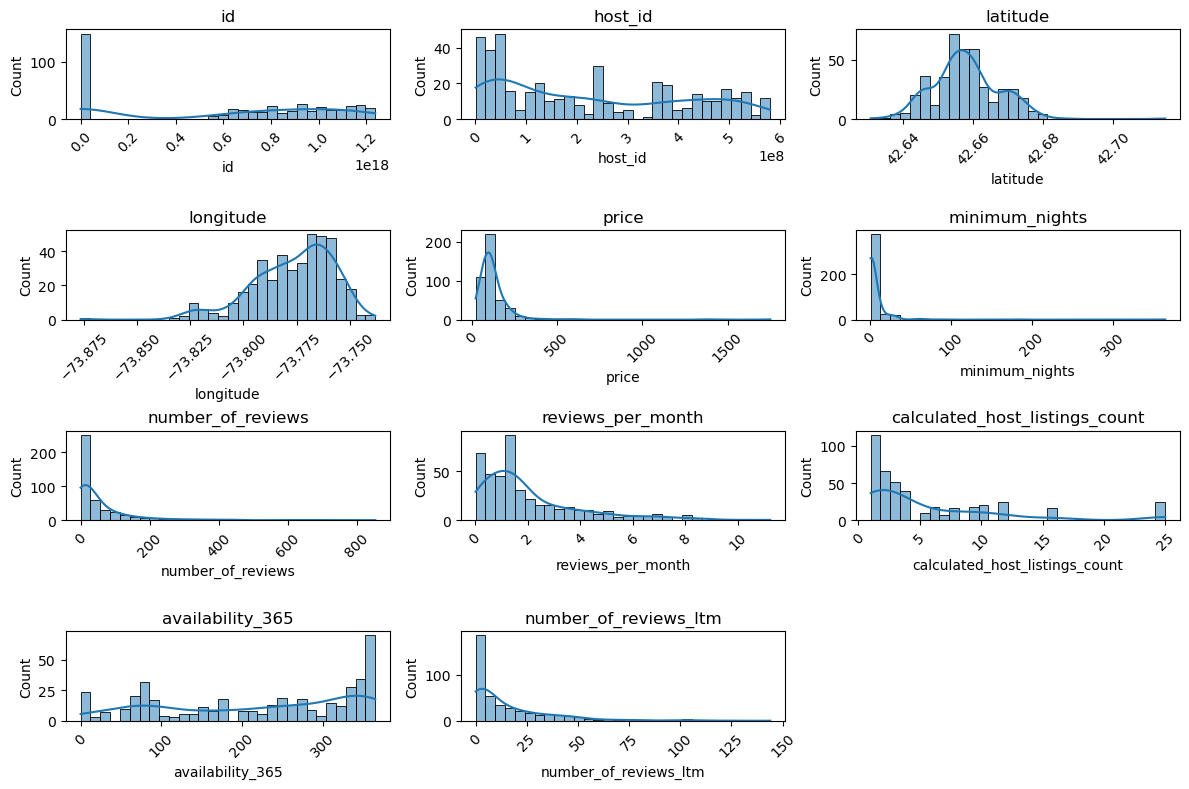

In [69]:
# 6. Plot Numerical Histograms
def plot_numerical_histograms(df):
    """Plots histograms for numerical columns, skipping empty ones.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    """

    # Select numerical types
    numerical_cols = df.select_dtypes(include=np.number)

    cols_to_plot = []  # Keep track of numerical and non-empty columns.
    for col in numerical_cols:
        if not pd.isna(df[col]).all():  # Check if not all values are NaN
            cols_to_plot.append(col)

    if not cols_to_plot:  # If there are no numerical columns to plot, return a message.
        print("No numerical columns to plot in DataFrame.")
        return

    num_cols = len(cols_to_plot)  # Only includes non-empty columns.
    num_rows = (num_cols + 2) // 3  # Correct the number of rows to display.

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 8))
    axes = axes.ravel()  # Flatten axes array for iteration.

    for i, col in enumerate(cols_to_plot):  # Only iterate through non-empty cols
        ax = axes[i]
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)

    # Turn off any extra axes if the number of plots is not a multiple of 3
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_numerical_histograms(df)                 # Visualize numerical data

### Observations:

Numerical Features:

- id, host_id: These appear to be unique identifiers and don't provide meaningful insights for analysis.

- latitude, longitude: The distribution is skewed, indicating a concentration of listings in certain areas.

- price: The price distribution is right-skewed, with most listings being relatively inexpensive.

- minimum_nights: The majority of listings have a minimum stay of 1 night.

- number_of_reviews, reviews_per_month, calculated_host_listings_count: These features show a right-skewed distribution, indicating that most listings have a smaller number of reviews and listings per host.

- availability_365: The distribution is right-skewed, with many listings having high availability.

- number_of_reviews_ltm: These features show a right-skewed distribution, indicating that most listings have a smaller yearly number of reviews.

### Is there a relationship between two numerical variables?  
Scatter plots help visualize relationships between numerical features.  
- This analysis can reveal linear or non-linear trends, clusters, or outliers.  
- It aids in understanding whether further statistical modeling, like regression, is appropriate.  

In this step, we use scatter plots to explore and interpret such relationships.  


In [ ]:
# 7. Function for Scatter Plot
def plot_scatter(x, y, data, title, xlabel, ylabel, hue=None):
    """
    Helper function to create scatter plots.

    Parameters:
    x (str): Column name for x-axis.
    y (str): Column name for y-axis.
    data (pd.DataFrame): DataFrame containing the data.
    title (str): Title of the plot.
    xlabel (str): Label for x-axis.
    ylabel (str): Label for y-axis.
    hue (str, optional): Column name for color coding.
    """
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=y, data=data, alpha=0.6, hue=hue, palette='cool')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if hue:
        plt.legend(title=hue, loc='upper right')
    plt.show()

### How do categories compare across a numerical variable?  
Bar plots provide insights into the distribution of a numerical variable across categories.  
- This can highlight differences in averages, sums, or counts across groups.  
- It helps identify trends and patterns that inform further analysis or decision-making.  

We use this step to compare categories effectively and uncover key trends.  


In [ ]:
# 8. Function for Bar Plot
def plot_bar(data, x, y, hue=None, title='', xlabel='', ylabel='', rotation=0):
    """
    Helper function to create bar plots.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    x (str): Column name for x-axis.
    y (str): Column name for y-axis.
    hue (str, optional): Column name for hue (categorical variable).
    title (str): Title of the plot.
    xlabel (str): Label for x-axis.
    ylabel (str): Label for y-axis.
    rotation (int, optional): Rotation angle for x-tick labels.
    """
    plt.figure(figsize=(12, 6))

    # If hue is provided, use it for coloring
    if hue:
        sns.barplot(data=data, x=x, y=y, hue=hue, palette='cool')
    else:
        # Use default colors if no hue is provided
        sns.barplot(data=data, x=x, y=y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha='right')

    # Check if hue is provided and has unique values for legend
    if hue:  # Improved legend handling
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:  # Check if any handles/labels exist.
            plt.legend(handles, labels, title=hue, loc='best')

    plt.tight_layout()
    plt.show()

## 6- Data Modeling
Here, we will build a simple linear regression model to predict Airbnb prices based on selected features.


### What factors most influence the price of an Airbnb listing in Albany? 
Pricing is a critical factor for both hosts and guests. Understanding the drivers of price can:  
- Help identify key features that impact revenue.  
- Provide insights for optimizing listing prices.  

In this step, we analyze various factors, such as location, room type, and availability, to understand their influence on pricing. This involves exploring correlations, running statistical tests, and using regression models to quantify the relationships.  


In [ ]:
# 9. Analyze price factors
def analyze_airbnb_price_factors(df):
    """
    Analyze the factors influencing Airbnb listing prices using linear regression.

    Parameters:
    df (pd.DataFrame): The preprocessed DataFrame containing Airbnb data.

    Returns:
    pd.DataFrame: A DataFrame containing the coefficients of the linear regression model for each feature.

    Process:
    1. Process 'last_review' to create binary features: 'has_last_review' and 'no_last_review'.
    2. Select relevant features and the target variable.
    3. Convert categorical variables to dummy variables for regression analysis.
    4. Split the dataset into training and testing sets.
    5. Train a linear regression model using a pipeline with standard scaling.
    6. Visualize the coefficients to interpret feature importance.
    7. Evaluate the model using R-squared, Mean Squared Error (MSE), and Cross-Validation.
    """

    # Create binary features for 'last_review'
    df['has_last_review'] = df['last_review'].apply(
        lambda x: 1 if x != 'No reviews' else 0)
    df['no_last_review'] = df['last_review'].apply(
        lambda x: 1 if x == 'No reviews' else 0)

    # Selecting relevant features for the analysis
    features = ['room_type', 'neighbourhood', 'minimum_nights',
                'number_of_reviews', 'reviews_per_month', 'availability_365',
                'has_last_review', 'no_last_review']
    target = 'price'

    # Preprocessing: Convert categorical variables to dummy variables
    df = pd.get_dummies(df[features + [target]], drop_first=True)

    # Splitting the dataset into training and testing sets
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)

    # Fitting the linear regression model using a pipeline
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)

    # Extracting and sorting the coefficients by absolute value
    coefficients = pd.DataFrame(
        model.named_steps['linearregression'].coef_,
        index=X.columns,  # Set the index to the feature names
        columns=['Coefficient']
    )
    coefficients = coefficients.reindex(
        coefficients['Coefficient'].abs().sort_values(ascending=False).index)

    # Resetting the index to create a proper DataFrame for plotting
    coefficients.reset_index(inplace=True)
    # Rename the index column for clarity
    coefficients.rename(columns={'index': 'Feature'}, inplace=True)

    # Create a new column to categorize coefficients as positive or negative
    coefficients['Sign'] = coefficients['Coefficient'].apply(
        lambda x: 'Positive' if x > 0 else 'Negative')

    # Visualizing the coefficients
    plot_bar(coefficients,
             x='Coefficient',
             y='Feature',  # Use the renamed column for y
             title='Factors Influencing Airbnb Listing Price',
             xlabel='Coefficient Value',
             ylabel='Features',
             hue='Sign',  # Use hue to color bars based on the sign of the coefficient
             rotation=0)

    # Model evaluation
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("\nModel Evaluation:")
    print(
        f"R-squared: {r2:.2f} - Indicates the proportion of variance explained by the model.")
    print(f"Mean Squared Error: {
          mse:.2f} - Measures the average squared difference between predicted and actual values.")

    # Cross-validation
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-Validated R-squared: {cross_val_scores.mean()
          :.2f} - Average R-squared across 5 folds.")

    return coefficients


analyze_airbnb_price_factors(df)             # Analyze price factors

### - Is there a correlation between listing price and availability throughout the year?
### - Is there a correlation between the number of reviews and availability?
 
Understanding the correlation between availability and other variables can:  
- Reveal patterns in booking behavior.  
- Provide insights into seasonality or high-demand periods.  


In [ ]:
# 10.Analyze availability correlation
def analyze_availability_correlation(df):
    """
    Analyze and visualize the correlation between availability (availability_365)
    and two key features: number of reviews and price.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing Airbnb data.

    Returns:
    None: Displays scatter plots and correlation values for the analysis.
    """

    # Correlation values
    correlation_reviews = df['availability_365'].corr(df['number_of_reviews'])
    correlation_price = df['availability_365'].corr(df['price'])

    print(f"Correlation between availability and number of reviews: {
          correlation_reviews:.2f}")
    print(f"Correlation between availability and price: {
          correlation_price:.2f}")

    # Scatter plot: Availability vs. Number of Reviews
    plot_scatter('availability_365', 'number_of_reviews', df,
                 'Availability vs. Number of Reviews',
                 'Availability (days/year)',
                 'Number of Reviews',
                 hue='room_type')

    # Scatter plot: Availability vs. Price
    plot_scatter('availability_365', 'price', df,
                 'Availability vs. Price',
                 'Availability (days/year)',
                 'Price ($)',
                 hue='room_type')


# Analyze correlations in availability
analyze_availability_correlation(df)

### Are there location-based trends in average price, number of reviews, or review frequency in Albany?
  
Location often plays a critical role in listing popularity.  
- We analyze geospatial patterns and distribution of listings by neighborhood or area.  


In [ ]:
# 11. Analyze location trends
def analyze_location_trends(df):
    """
    Analyze location-based trends in reviews, pricing, and popularity.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing Airbnb data.

    Returns:
    None: Displays bar plots and summary statistics highlighting location-based trends.
    """

    # Group by neighborhood
    location_stats = df.groupby('neighbourhood').agg({
        'price': 'mean',
        'number_of_reviews': 'mean',
        'reviews_per_month': 'mean'
    }).reset_index()

    # Rename columns for clarity
    location_stats.rename(columns={
        'price': 'Average Price',
        'number_of_reviews': 'Average Number of Reviews',
        'reviews_per_month': 'Average Reviews Per Month'
    }, inplace=True)

    # Sort by Average Price for visualization and rounding to 2 decimal places
    location_stats = location_stats.sort_values(
        by='Average Price', ascending=False).round(2)

    # Display summary statistics
    print("Location-Based Trends:\n")
    print(tabulate(location_stats, headers='keys', tablefmt='pretty'))

    # Bar plot: Average Price by Neighborhood
    plot_bar(location_stats,
             x='neighbourhood',
             y='Average Price',
             title='Average Price by Neighborhood',
             xlabel='Neighborhood',
             ylabel='Average Price ($)',
             hue='neighbourhood',  # Specify hue for coloring
             rotation=45)

    # Bar plot: Average Number of Reviews by Neighborhood
    plot_bar(location_stats,
             x='neighbourhood',
             y='Average Number of Reviews',
             title='Average Number of Reviews by Neighborhood',
             xlabel='Neighborhood',
             ylabel='Average Number of Reviews',
             hue='neighbourhood',  # Specify hue for coloring
             rotation=45)

    # Bar plot: Average Reviews Per Month by Neighborhood
    plot_bar(location_stats,
             x='neighbourhood',
             y='Average Reviews Per Month',
             title='Average Reviews Per Month by Neighborhood',
             xlabel='Neighborhood',
             ylabel='Average Reviews Per Month',
             hue='neighbourhood',  # Specify hue for coloring
             rotation=45)


analyze_location_trends(df)                  # Explore trends by location

### How does the room type affect the average price and availability of listings?
  
Room type can affect pricing, availability, and customer preferences.  
- This analysis uncovers trends in the distribution and popularity of room types.  


In [ ]:
# 12. Analyze Room Type Trends
def analyze_room_type_trends(df):
    """
    Analyze trends in average price and availability based on room type.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing Airbnb data.

    Returns:
    None: Displays bar plots for room type trends.
    """
    if 'room_type' not in df.columns or 'price' not in df.columns:
        raise ValueError(
            "DataFrame must contain 'room_type' and 'price' columns.")

    # Group by room type
    room_type_stats = df.groupby('room_type').agg({
        'price': 'mean',
        'availability_365': 'mean'
    }).reset_index().round(2)

    # Save summary to CSV
    room_type_stats.to_csv("room_type_trends.csv", index=False)

    # Bar plot: Average Price by Room Type
    plot_bar(room_type_stats,
             x='room_type',
             y='price',
             title='Average Price by Room Type',
             xlabel='Room Type',
             ylabel='Average Price ($)',
             hue='room_type',  # Specify hue for coloring
             rotation=45)

    # Bar plot: Average Availability by Room Type
    plot_bar(room_type_stats,
             x='room_type',
             y='availability_365',
             title='Average Availability by Room Type',
             xlabel='Room Type',
             ylabel='Average Availability (Days)',
             hue='room_type',  # Specify hue for coloring
             rotation=45)


# Examine room type distribution and trends
analyze_room_type_trends(df)

### Do listings with more frequent reviews tend to have higher/lower prices or higher/lower availability?
 
Reviews provide customer feedback and can influence:  
- Listing visibility.  
- Booking rates.  
We analyze how the number and quality of reviews impact various aspects of the listings.  


In [ ]:
# 13.Analyze review impact
def analyze_review_impact(df):
    """
    Analyze the impact of the number of reviews on pricing and ratings.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing Airbnb data.

    Returns:
    None: Displays scatter plots and correlation values for the analysis.
    """

    # Correlation values
    correlation_price = df['number_of_reviews'].corr(df['price'])
    correlation_reviews_month = df['number_of_reviews'].corr(
        df['reviews_per_month'])

    print(f"Correlation between number of reviews and price: {
          correlation_price:.2f}")
    print(f"Correlation between number of reviews and reviews per month: {
          correlation_reviews_month:.2f}")

    # Scatter plot: Number of Reviews vs. Price
    plot_scatter('number_of_reviews', 'price', df,
                 'Number of Reviews vs. Price',
                 'Number of Reviews',
                 'Price ($)',
                 hue='room_type')

    # Scatter plot: Number of Reviews vs. Reviews Per Month
    plot_scatter('number_of_reviews', 'reviews_per_month', df,
                 'Number of Reviews vs. Reviews per Month',
                 'Number of Reviews',
                 'Reviews per Month',
                 hue='room_type')


# Assess the impact of reviews on listings
analyze_review_impact(df)